# ARIMA Forecasting
## Comparing Kept vs Lost Status
The code below fits an ARIMA model to two companys, one which maintained Champion status and another that lost Champion status, in order to compare the model's forecasts for the two scenarios.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [2]:
warnings.filterwarnings('ignore')    # ignore warnings

In [3]:
dividend_files = os.listdir('../data/series/good')    # location of data

In [4]:
good_company = dividend_files[1]    # this company kept status
bad_company = dividend_files[2]    # this company lost status

In [5]:
# Get names of companies
good_company_name = good_company.split('_')[0]
bad_company_name = bad_company.split('_')[0]

In [6]:
# Create df
good_company_df = pd.read_csv("../data/series/good/" + good_company)
good_company_df.rename(columns = {'0': 'Dividends'}, inplace = True)
good_company_df.head(5)

,Date,Dividends
0,1984-10-09,0.0205
1,1984-10-09,0.0205
2,1984-10-09,0.0205
3,1984-10-09,0.0205
4,1985-01-10,0.0215


In [7]:
# Create df
bad_company_df = pd.read_csv("../data/series/good/" + bad_company)
bad_company_df.rename(columns = {'0': 'Dividends'}, inplace = True)
bad_company_df.head(5)

,Date,Dividends
0,1983-01-11,0.005892
1,1983-04-11,0.007014
2,1983-07-11,0.007014
3,1983-10-07,0.007014
4,1984-01-09,0.007014


In [8]:
# Get dividend values
good_company_dividends = good_company_df['Dividends']
bad_company_dividends = bad_company_df['Dividends']

Text(0.5, 1.0, 'ABT - Dividends')

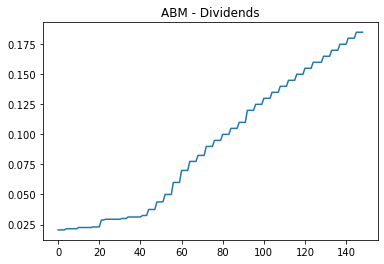

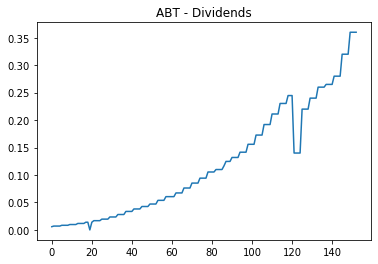

In [9]:
# Plot dividends over time
plt.figure()
plt.plot(good_company_dividends)
plt.title(f'{good_company_name} - Dividends')
plt.figure()
plt.plot(bad_company_dividends)
plt.title(f'{bad_company_name} - Dividends')

As can be seen above, ABT loses status around the 120 mark.

Also we can see from the graphs that the data is not stationary so the first difference will need to be taken (or possibly more) to make it stationary.

Text(0.5, 1.0, 'ABT Dividends - Autocorrelation plot with lag = 1')

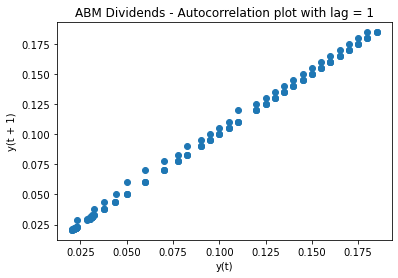

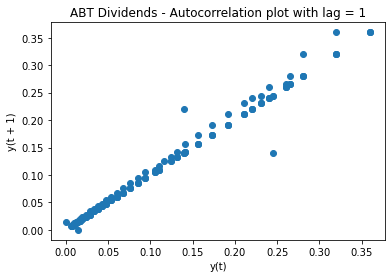

In [10]:
# Plot lag plots to show autocorrelation
plt.figure()
lag_plot(good_company_dividends, lag=1)
plt.title(f'{good_company_name} Dividends - Autocorrelation plot with lag = 1')
plt.figure()
lag_plot(bad_company_dividends, lag=1)
plt.title(f'{bad_company_name} Dividends - Autocorrelation plot with lag = 1')

The ADF test is used to test for stationarity. The p-value should be less than 0.5 for the data to be stationary.

In [11]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [12]:
print(good_company_name)
print('-----')
perform_adf_test(good_company_dividends)
print(bad_company_name)
print('-----')
perform_adf_test(bad_company_dividends)

ABM
-----
ADF Statistic: 0.649370
p-value: 0.988771
ABT
-----
ADF Statistic: 0.690224
p-value: 0.989641


The original data is not stationary. Getting the first difference should make it stationary.

In [13]:
good_company_diff_dividends = good_company_dividends.diff(1).dropna()
bad_company_diff_dividends = bad_company_dividends.diff(1).dropna()

In [14]:
print(good_company_name)
print('-----')
perform_adf_test(good_company_diff_dividends)
print(bad_company_name)
print('-----')
perform_adf_test(bad_company_diff_dividends)

ABM
-----
ADF Statistic: -3.096103
p-value: 0.026843
ABT
-----
ADF Statistic: -12.690447
p-value: 0.000000


The p-values for both are now below 0.05 and therefore the first difference is stationary.

Text(0.5, 1.0, 'ABT - Dividends - First Difference')

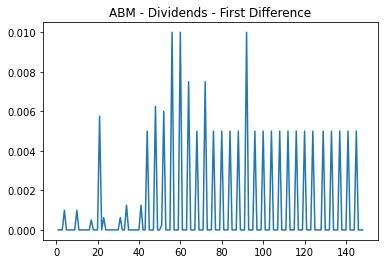

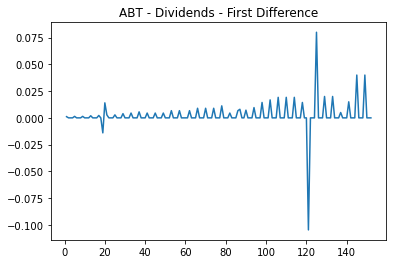

In [15]:
# Plot the first difference of the dividends
plt.figure()
plt.plot(good_company_diff_dividends)
plt.title(f'{good_company_name} - Dividends - First Difference')
plt.figure()
plt.plot(bad_company_diff_dividends)
plt.title(f'{bad_company_name} - Dividends - First Difference')

Looking at the data above we can tell it is now stationary.

ABM - PACF Plot


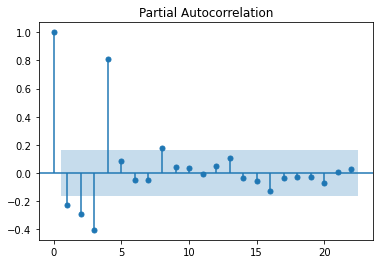

In [16]:
plot_pacf = plot_pacf(good_company_diff_dividends)
print(f'{good_company_name} - PACF Plot')

ABM - ACF Plot


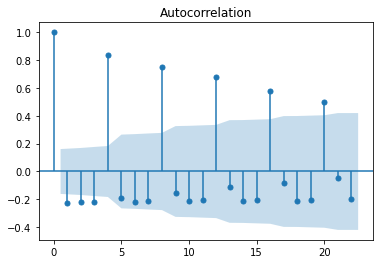

In [17]:
plot_acf = plot_acf(good_company_diff_dividends)
print(f'{good_company_name} - ACF Plot')

In [18]:
# ARIMA
# Create model and get forecasts for both companies
good_company_train_data, good_company_test_data = good_company_df[0:int(len(good_company_df)*0.7)], good_company_df[int(len(good_company_df)*0.7):]    # split train and test data
good_company_training_data = good_company_train_data['Dividends'].values   
good_company_test_data = good_company_test_data['Dividends'].values
good_company_history = [x for x in good_company_training_data]    # make list of training data
good_company_model_predictions = []

bad_company_train_data, bad_company_test_data = bad_company_df[0:int(len(bad_company_df)*0.7)], bad_company_df[int(len(bad_company_df)*0.7):]    # split train and test data
bad_company_training_data = bad_company_train_data['Dividends'].values   
bad_company_test_data = bad_company_test_data['Dividends'].values
bad_company_history = [x for x in bad_company_training_data]    # make list of training data
bad_company_model_predictions = []

for time_point in range(len(good_company_test_data)):
    good_company_model = ARIMA(good_company_history, order=(4, 1, 4))
    good_company_model_fit = good_company_model.fit()    # fit model
    good_company_output = good_company_model_fit.forecast()    # get out-of-sample forecasts (predictions)
    good_company_yhat = good_company_output[0]    # get value from array
    good_company_model_predictions.append(good_company_yhat)    # list of model predictions
    good_company_true_test_value = good_company_test_data[time_point]    # get true value
    good_company_history.append(good_company_true_test_value)    # append to history (training data)
    
for time_point in range(len(bad_company_test_data)):
    bad_company_model = ARIMA(bad_company_history, order=(1, 1, 1))
    bad_company_model_fit = bad_company_model.fit()    # fit model
    bad_company_output = bad_company_model_fit.forecast()    # get out-of-sample forecasts (predictions)
    bad_company_yhat = bad_company_output[0]    # get value from array
    bad_company_model_predictions.append(bad_company_yhat)    # list of model predictions
    bad_company_true_test_value = bad_company_test_data[time_point]    # get true value
    bad_company_history.append(bad_company_true_test_value)    # append to history (training data)
    
good_company_MSE_error = mean_squared_error(good_company_test_data, good_company_model_predictions)
print(f'{good_company_name} - Testing Mean Squared Error - {good_company_MSE_error:.5f}')

bad_company_MSE_error = mean_squared_error(bad_company_test_data, bad_company_model_predictions)
print(f'{bad_company_name} - Testing Mean Squared Error - {bad_company_MSE_error:.5f}')

ABM - Testing Mean Squared Error - 0.00000
ABT - Testing Mean Squared Error - 0.00049


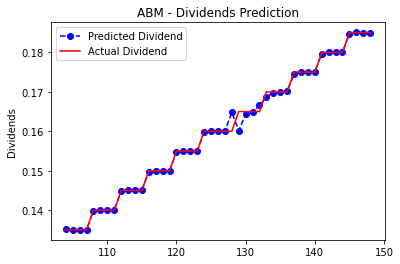

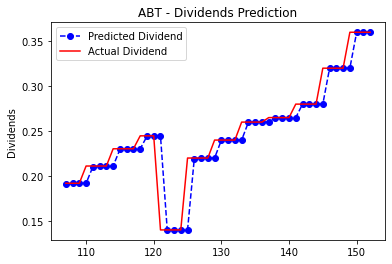

In [19]:
# Plot forecast predictions against test dataset
good_company_test_set_range = good_company_df[int(len(good_company_df)*0.7):].index
plt.figure()
plt.plot(good_company_test_set_range, good_company_model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Dividend')
plt.plot(good_company_test_set_range, good_company_test_data, color='red', label='Actual Dividend')
plt.title(f'{good_company_name} - Dividends Prediction')
#plt.xlabel('Date')
plt.ylabel('Dividends')
#plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
#plt.savefig("ABM_ARIMA.jpg")

bad_company_test_set_range = bad_company_df[int(len(bad_company_df)*0.7):].index
plt.figure()
plt.plot(bad_company_test_set_range, bad_company_model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Dividend')
plt.plot(bad_company_test_set_range, bad_company_test_data, color='red', label='Actual Dividend')
plt.title(f'{bad_company_name} - Dividends Prediction')
#plt.xlabel('Date')
plt.ylabel('Dividends')
#plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
#plt.savefig("ABT_ARIMA.jpg")